In [5]:
from pathlib import Path
import re, json, random, math
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Polygon
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

IMG_DIR = Path("test/images")
LBL_DIR = Path("test/labels")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Download test dataset:
wget -O test_images_labels_targets.tar.gz "https://download.xview2.org/test_images_labels_targets.tar.gz?Expires=1757227443&Signature=j-D00P9HP5NU3fykBQ4R9CHRAN~7IjSuV-d4ZDEpmgF4nztfd5c1MH~ZYFpjuGpqCbooCE0VAUu5R1k~~zRfauCgAYL~~e5SVEQ1m~Cw3OnZdYceFYWZcIZNfivmN379KLLrbPTt~zfoUlfNBGdCbjbQ0URHl7XtnK6Evhdoc6E7o5OOI5jp9Hc0YYf5tRF0YRzvXRiPPaxqolZUoHkjJwGqucZ96IPjwdLMlADHcr~4ucwr0O2bbSS674cEdlr79QJWPc~GzrtdFiY2t2fVjOxc8OKz9WTetUebdxNGXoxk5C51SgjoZXZEbAjTrVqZBP2YdyyMiDPsh4R7HGmOlQ__&Key-Pair-Id=APKAIKGDJB5C3XUL2DXQ"
Verify the SHA1 checksum:
sha1sum test_images_labels_targets.tar.gz
Check that the output matches:
86ed3dba2f8d16ceceb75d451005054fefa9616f
Extract the archive:
tar -xzvf test_images_labels_targets.tar.gz

In [6]:
def is_pre(path: Path):
    return "_pre_disaster" in path.name

def paired_pre_files(img_dir=IMG_DIR, lbl_dir=LBL_DIR):
    imgs = sorted([p for p in img_dir.glob("*.png") if is_pre(p)])
    pairs = []
    for ip in imgs:
        jp = lbl_dir / ip.with_suffix(".json").name
        if jp.exists() and is_pre(jp):
            pairs.append((ip, jp))
    return pairs

pairs = paired_pre_files()
len(pairs), pairs[:3]


(933,
 [(PosixPath('test/images/guatemala-volcano_00000003_pre_disaster.png'),
   PosixPath('test/labels/guatemala-volcano_00000003_pre_disaster.json')),
  (PosixPath('test/images/guatemala-volcano_00000005_pre_disaster.png'),
   PosixPath('test/labels/guatemala-volcano_00000005_pre_disaster.json')),
  (PosixPath('test/images/guatemala-volcano_00000009_pre_disaster.png'),
   PosixPath('test/labels/guatemala-volcano_00000009_pre_disaster.json'))])

In [7]:
def load_img(path: Path):
    return np.array(Image.open(path).convert("RGB"))

def mask_from_json(json_path: Path, image_shape):
    meta = json.loads(json_path.read_text())
    H, W = image_shape[:2]
    mask = np.zeros((H, W), dtype=np.uint8)
    feats = meta["features"]["xy"]  # <- pixel coordinates
    for f in feats:
        poly = wkt.loads(f["wkt"])
        pts = np.array(poly.exterior.coords, dtype=np.int32)
        cv2.fillPoly(mask, [pts], 1)
    return mask

def show_overlay(img, mask, alpha=0.4):
    overlay = img.copy()
    color = np.array([255,0,0], dtype=np.uint8)
    overlay[mask.astype(bool)] = (alpha*color + (1-alpha)*overlay[mask.astype(bool)]).astype(np.uint8)
    plt.figure(figsize=(6,6))
    plt.imshow(overlay); plt.axis("off"); plt.show()


socal-fire_00000170_pre_disaster.png — buildings: 9127


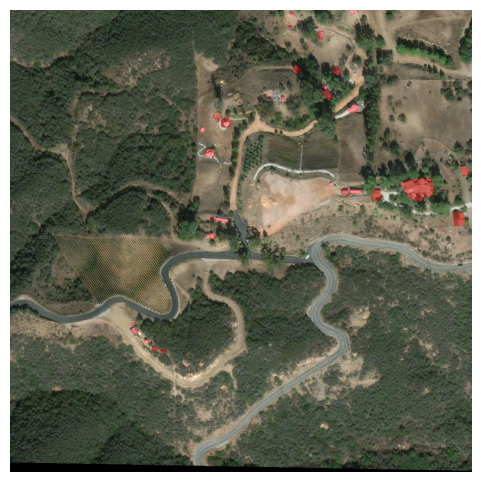

hurricane-harvey_00000011_pre_disaster.png — buildings: 234677


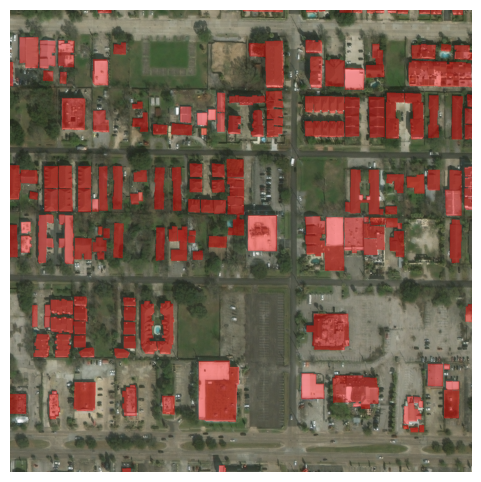

hurricane-florence_00000125_pre_disaster.png — buildings: 1183


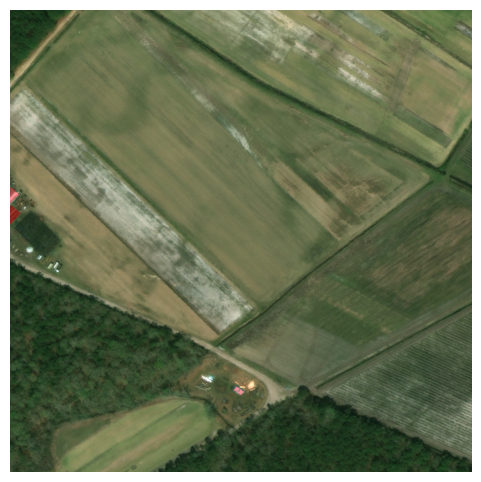

socal-fire_00000625_pre_disaster.png — buildings: 0


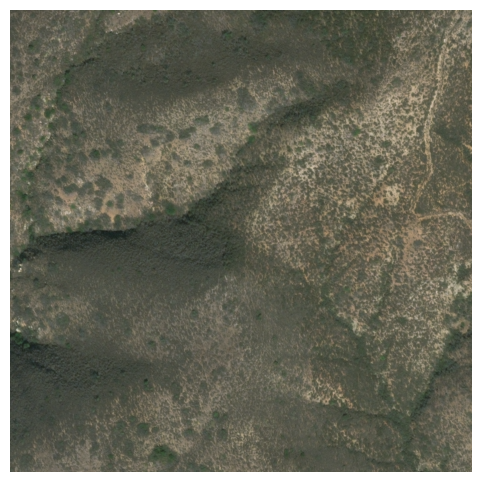

hurricane-matthew_00000345_pre_disaster.png — buildings: 293134


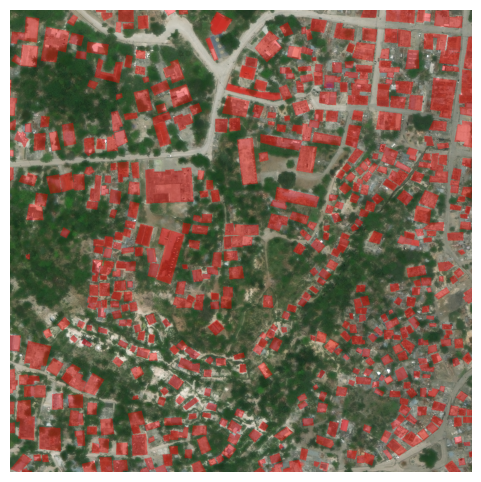

In [8]:
for _ in range(5):
    ip, jp = random.choice(pairs)
    img = load_img(ip)
    m = mask_from_json(jp, img.shape)
    print(ip.name, "— buildings:", int(m.sum()))
    show_overlay(img, m)


In [9]:
import pandas as pd

def poly_stats(json_path):
    meta = json.loads(json_path.read_text())
    polys = [wkt.loads(f["wkt"]) for f in meta["features"]["xy"]]
    areas = [p.area for p in polys]
    perims = [p.length for p in polys]
    rect_ratios = []
    for p in polys:
        minx,miny,maxx,maxy = p.bounds
        w = maxx-minx; h = maxy-miny
        rect_ratios.append((min(w,h)+1e-6)/(max(w,h)+1e-6))
    return dict(
        n=len(polys),
        area_mean=np.mean(areas) if areas else 0,
        area_med=np.median(areas) if areas else 0,
        perim_mean=np.mean(perims) if perims else 0,
        rect_ratio_mean=np.mean(rect_ratios) if rect_ratios else 0
    )

rows = []
for ip,jp in pairs[:200]:  # cap for speed
    rows.append({"img": ip.name, **poly_stats(jp)})
df = pd.DataFrame(rows)
print(df.describe().T)


                 count         mean          std  min         25%         50%  \
n                200.0    39.225000    59.582672  0.0    4.000000   11.000000   
area_mean        200.0  1235.628805  2574.421017  0.0  455.838815  762.544712   
area_med         200.0   760.488627   672.570556  0.0  313.213778  604.956350   
perim_mean       200.0   121.980781    85.990755  0.0   86.285753  112.282733   
rect_ratio_mean  200.0     0.717372     0.221956  0.0    0.714623    0.773656   

                         75%           max  
n                  43.250000    274.000000  
area_mean        1304.724302  30802.786395  
area_med         1053.607147   5211.988278  
perim_mean        149.845979    862.200510  
rect_ratio_mean     0.832045      0.994737  


In [10]:
def generate_windows(H, W, tile=512, stride=384):
    ys = list(range(0, max(1, H - tile + 1), stride)) or [0]
    xs = list(range(0, max(1, W - tile + 1), stride)) or [0]
    for y in ys:
        for x in xs:
            yield slice(y, y+tile), slice(x, x+tile)

class FootprintDataset(Dataset):
    def __init__(self, pairs, tile=512, stride=384, augment=True, oversample_pos=True):
        self.records = []
        self.tile, self.stride = tile, stride
        self.augment = augment
        self.oversample_pos = oversample_pos

        self.T = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            ToTensorV2(),
        ]) if augment else A.Compose([ToTensorV2()])

        # Precompute windows per image (for deterministic sampling / oversampling)
        for ip, jp in pairs:
            img = load_img(ip)
            H, W = img.shape[:2]
            mask = mask_from_json(jp, img.shape)
            pos_windows, neg_windows = [], []
            for ys, xs in generate_windows(H, W, tile, stride):
                m = mask[ys, xs]
                (pos_windows if m.any() else neg_windows).append((ys, xs))
            self.records.append(dict(ip=ip, jp=jp, H=H, W=W,
                                     pos=pos_windows, neg=neg_windows))

    def __len__(self):
        # one “epoch” pass worth of tiles; tweak as desired
        return sum(len(r["pos"]) + max(0, len(r["pos"]) if self.oversample_pos else len(r["neg"])) for r in self.records)

    def __getitem__(self, idx):
        # sample: prefer positives then sprinkle negatives for balance
        r = random.choice(self.records)
        choose_pos = (len(r["pos"])>0) and (self.oversample_pos or random.random() < 0.5)
        win_list = r["pos"] if (choose_pos and r["pos"]) else (r["neg"] or r["pos"])
        ys, xs = random.choice(win_list)

        img = load_img(r["ip"])[ys, xs]
        msk = mask_from_json(r["jp"], (r["H"], r["W"]))[ys, xs]

        data = self.T(image=img, mask=msk)
        x = (data["image"].float()/255.0)
        y = data["mask"].unsqueeze(0).float()
        return x, y


In [11]:
def make_model():
    return smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1
    )

def dice_loss(logits, target, eps=1e-6):
    p = torch.sigmoid(logits)
    num = 2*(p*target).sum(dim=(2,3)) + eps
    den = p.sum(dim=(2,3)) + target.sum(dim=(2,3)) + eps
    return 1 - (num/den).mean()

bce = nn.BCEWithLogitsLoss()

def total_loss(logits, target):
    return 0.5*bce(logits, target) + 0.5*dice_loss(logits, target)

@torch.no_grad()
def iou_metric(logits, target, thr=0.5, eps=1e-6):
    p = (torch.sigmoid(logits) > thr).float()
    inter = (p*target).sum(dim=(2,3))
    union = p.sum(dim=(2,3)) + target.sum(dim=(2,3)) - inter + eps
    return (inter/union).mean().item()


In [3]:
# --- config ---
USE_GPU_INDEX = 1            # set to 1 to target the problematic GPU; set to 0 for the first GPU
BATCH_SIZE = 6
MAX_TRAIN_STEPS = 20         # short run for memcheck
EPOCHS = 1                   # keep tiny for memcheck

# --- data ---
train_ds = FootprintDataset(train_pairs, tile=512, stride=384, augment=True,  oversample_pos=True)
val_ds   = FootprintDataset(val_pairs,   tile=512, stride=384, augment=False, oversample_pos=False)

# Tip: for memcheck use num_workers=0 and pin_memory=False to reduce noise
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=False)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

# --- device ---
if torch.cuda.is_available():
    device = f"cuda:{USE_GPU_INDEX}"
else:
    device = "cpu"

model = make_model().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device.startswith("cuda")))
print(f"Using device: {device}")

best_iou = 0.0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running, seen, step = 0.0, 0, 0

    for xb, yb in train_dl:
        step += 1
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        # helpful sanity checks (catch shape/type bugs early)
        assert xb.ndim == 4, f"xb shape unexpected: {xb.shape}"
        assert yb.ndim in (3, 4), f"yb shape unexpected: {yb.shape}"
        if yb.ndim == 3:  # (N,H,W) -> (N,1,H,W)
            yb = yb.unsqueeze(1).float()
        assert xb.shape[0] == yb.shape[0], f"batch mismatch: {xb.shape} vs {yb.shape}"

        opt.zero_grad(set_to_none=True)
        torch.cuda.synchronize() if device.startswith("cuda") else None  # align errors to this site

        with torch.cuda.amp.autocast(enabled=device.startswith("cuda")):
            logits = model(xb)
            # ensure spatial dims match mask
            assert logits.shape[-2:] == yb.shape[-2:], f"spatial mismatch: {logits.shape} vs {yb.shape}"
            loss = total_loss(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        running += loss.item() * xb.size(0)
        seen    += xb.size(0)

        if step >= MAX_TRAIN_STEPS:
            break

    train_loss = running / max(1, seen)

    # ---- validation ----
    model.eval()
    ious = []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            if yb.ndim == 3:
                yb = yb.unsqueeze(1).float()
            logits = model(xb)
            ious.append(float(iou_metric(logits, yb)))
    miou = float(np.mean(ious)) if ious else 0.0

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_mIoU={miou:.4f}")

    if miou > best_iou:
        best_iou = miou
        torch.save(model.state_dict(), "best_unet.pt")

print("Best IoU:", best_iou)

NameError: name 'pairs' is not defined

In [9]:
@torch.no_grad()
def predict_prob_map(image_path, ckpt="best_unet.pt", tile=512, stride=384, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = make_model().to(device)
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()

    img = load_img(image_path).astype(np.float32)/255.0
    H,W,_ = img.shape
    prob = np.zeros((H,W), dtype=np.float32)
    cnt  = np.zeros((H,W), dtype=np.float32)

    for ys, xs in generate_windows(H, W, tile, stride):
        tile_img = img[ys, xs]
        x = torch.from_numpy(tile_img.transpose(2,0,1)).unsqueeze(0).to(device)
        p = torch.sigmoid(model(x)).squeeze().cpu().numpy()
        prob[ys, xs] += p
        cnt[ys, xs]  += 1.0

    prob /= np.maximum(cnt, 1e-6)
    return prob

def prob_to_mask(prob, thr=0.5, min_hole=16, min_obj=64):
    mask = (prob > thr).astype(np.uint8)
    # fill small holes
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    # remove tiny blobs
    num, comp = cv2.connectedComponents(mask, connectivity=8)
    out = np.zeros_like(mask)
    for lab in range(1, num):
        area = (comp==lab).sum()
        if area >= min_obj:
            out[comp==lab] = 1
    return out

In [27]:
import os
from shapely.geometry import Polygon
from pathlib import Path

def mask_to_polygons(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for cnt in contours:
        if len(cnt) >= 3:
            poly = Polygon(cnt.squeeze())
            if poly.is_valid and poly.area > 0:
                polygons.append(poly)
    return polygons

def save_pred_json(image_path, pred_mask, out_dir):
    polygons = mask_to_polygons(pred_mask)
    features = [{"wkt": poly.wkt} for poly in polygons]
    result = {"features": {"xy": features}}
    out_path = Path(out_dir) / Path(image_path).with_suffix('.json').name
    with open(out_path, "w") as f:
        json.dump(result, f)

# Make sure output directory exists
os.makedirs("predicted_jsons", exist_ok=True)

# Predict and save polygons for a few validation images
for ip, jp in val_pairs[:20]:
    img = load_img(ip)
    with torch.no_grad():
        x = torch.from_numpy(img.transpose(2,0,1)).unsqueeze(0).float().to(device) / 255.0
        pred_mask = torch.sigmoid(model(x)).squeeze().cpu().numpy() > 0.5
    save_pred_json(ip, pred_mask.astype(np.uint8), "predicted_jsons")
    print(f"Saved predicted polygons for {ip.name} to predicted_jsons/{Path(ip).with_suffix('.json').name}")

Saved predicted polygons for socal-fire_00001141_pre_disaster.png to predicted_jsons/socal-fire_00001141_pre_disaster.json
Saved predicted polygons for socal-fire_00001138_pre_disaster.png to predicted_jsons/socal-fire_00001138_pre_disaster.json
Saved predicted polygons for midwest-flooding_00000088_pre_disaster.png to predicted_jsons/midwest-flooding_00000088_pre_disaster.json
Saved predicted polygons for midwest-flooding_00000309_pre_disaster.png to predicted_jsons/midwest-flooding_00000309_pre_disaster.json
Saved predicted polygons for hurricane-michael_00000030_pre_disaster.png to predicted_jsons/hurricane-michael_00000030_pre_disaster.json
Saved predicted polygons for hurricane-florence_00000187_pre_disaster.png to predicted_jsons/hurricane-florence_00000187_pre_disaster.json
Saved predicted polygons for socal-fire_00000414_pre_disaster.png to predicted_jsons/socal-fire_00000414_pre_disaster.json
Saved predicted polygons for hurricane-florence_00000204_pre_disaster.png to predicte

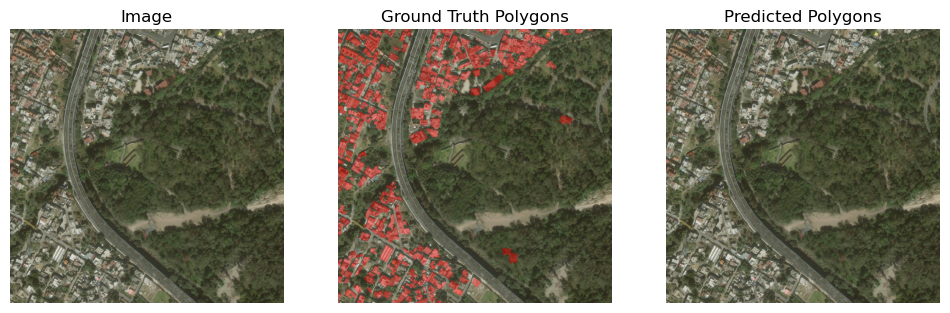

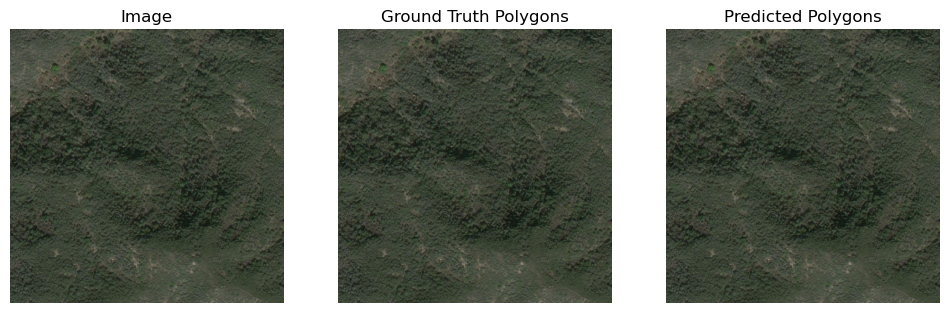

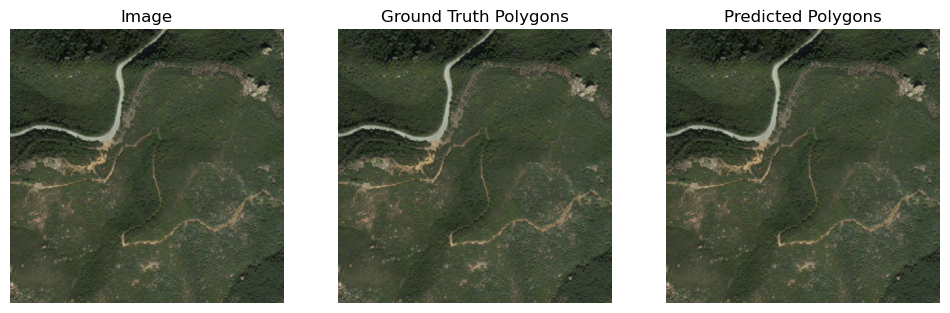

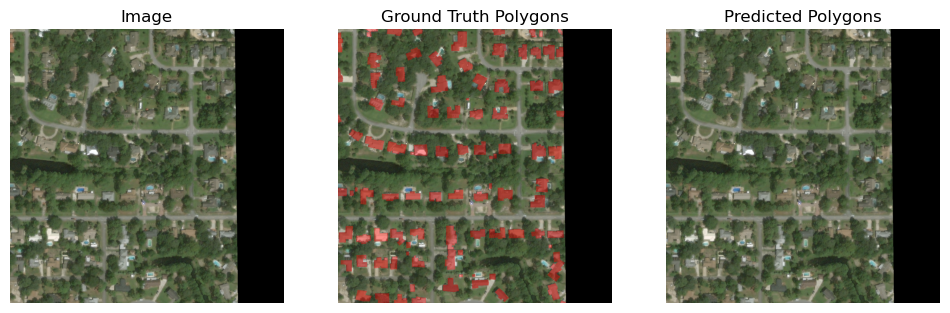

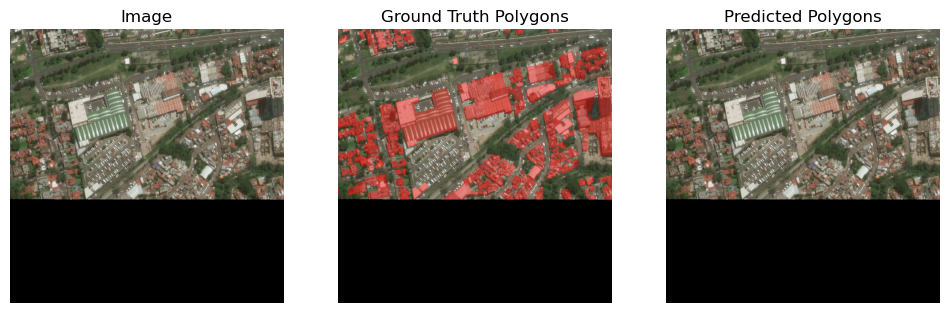

In [29]:
from shapely import wkt

def draw_polygons_on_image(img, polygons, color=(0,255,0), alpha=0.4):
    overlay = img.copy()
    for poly in polygons:
        pts = np.array(poly.exterior.coords, np.int32)
        cv2.fillPoly(overlay, [pts], color)
    return cv2.addWeighted(overlay, alpha, img, 1-alpha, 0)

def load_pred_polygons(json_path):
    meta = json.loads(Path(json_path).read_text())
    return [wkt.loads(f["wkt"]) for f in meta["features"]["xy"]]

def show_val_predictions_with_gt_and_pred(val_pairs, pred_dir="predicted_jsons", num_samples=5):
    for i in range(num_samples):
        ip, jp = random.choice(val_pairs)
        img = load_img(ip)
        gt_polys = []
        gt_meta = json.loads(Path(jp).read_text())
        for f in gt_meta["features"]["xy"]:
            gt_polys.append(wkt.loads(f["wkt"]))
        pred_json = Path(pred_dir) / Path(ip).with_suffix('.json').name
        if pred_json.exists():
            pred_polys = load_pred_polygons(pred_json)
        else:
            pred_polys = []
        img_gt = draw_polygons_on_image(img, gt_polys, color=(255,0,0), alpha=0.4)
        img_pred = draw_polygons_on_image(img, pred_polys, color=(0,255,0), alpha=0.4)
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title("Image")
        plt.imshow(img)
        plt.axis("off")
        plt.subplot(1,3,2)
        plt.title("Ground Truth Polygons")
        plt.imshow(img_gt)
        plt.axis("off")
        plt.subplot(1,3,3)
        plt.title("Predicted Polygons")
        plt.imshow(img_pred)
        plt.axis("off")
        plt.show()

# Show overlay of predicted polygons and ground truth polygons for validation samples
show_val_predictions_with_gt_and_pred(val_pairs, pred_dir="predicted_jsons", num_samples=5)

In [4]:
# save_preview.py
import os, numpy as np, rasterio
from PIL import Image

p = "ard_z11_031311102233_20250113_visual.tif"
assert os.path.exists(p), f"File not found: {p}"

with rasterio.open(p) as src:
    print("CRS:", src.crs)
    print("Size:", src.width, "x", src.height, "Bands:", src.count, "Dtype:", src.dtypes[0])
    img = src.read()  # (C, H, W)
    nodata = src.nodata
    mask = np.any(img == nodata, axis=0) if nodata is not None else None

# Expect RGB already; convert to HxWxC
img = np.transpose(img, (1, 2, 0))

# Scale to 8-bit for display if needed
if img.dtype != np.uint8:
    # robust 2–98% stretch
    lo = np.percentile(img, 2)
    hi = np.percentile(img, 98)
    img = np.clip((img - lo) / max(hi - lo, 1e-6), 0, 1)
    img = (img * 255).astype(np.uint8)

# Apply nodata as transparency if present
if mask is not None:
    alpha = (~mask).astype(np.uint8) * 255
    out = np.dstack([img, alpha])
    mode = "RGBA"
else:
    out = img
    mode = "RGB"

Image.fromarray(out, mode).save("ard_z11_031311102233_20250113_preview.png")
print("Saved: ard_z11_031311102233_20250113_preview.png")


CRS: EPSG:32611
Size: 17408 x 17408 Bands: 3 Dtype: uint8


/tmp/ipykernel_590037/4181001586.py:35: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(out, mode).save("ard_z11_031311102233_20250113_preview.png")


Saved: ard_z11_031311102233_20250113_preview.png
